In [1]:
import time
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# 0. Using ChatGPT to help you understand optimizers

Recently I had an interview question for Deep Learning candidates, and they were not able to answer these questions. 

Write one paragraph with the help of ChatGPT (or equivalent) explaining each one of the following optimizers, and in the last paragraph, reviewed by the notes from the lab last week, write a comparison of the advantages and disadvantages of each one.  Please note that ChatGPT may hallucinate, so you need to double-check what ChatGPT answers. 

- Stochastic Gradient Descent
- SGD with momentum
- RMSProp
- Adadelta
- Adam
- Adam with warmup

### Stochastic Gradient Descent

SGD is a variant of the gradient descent, which selects a batch of datapoints to calculate the gradient. This reduces computational time as it frequently updates. Allows for use on larger datasets to train as it reduces the amount of data points to just a subset. Compared to normal gradiant descent, which the computational cost increases linearly with n in O(n), SGD reduces at each iteration to O(1). It's is also used to get a general estimate of the gradient. SGD also is more noisy due to its randomness, where the learning rate comes in ti improve the quality of the stochastic gradient.
Since it is stochastic, SGD also has variability in its results, leating to oscillations nad instability. Can make convergence challenging with fine tuning the learning rate.

### SGD with momentum

Iteration of SGD that accelerating SGD being much more effective in problems that are ill-conditioned. It navigates through relevant directions, where some directions are slower than in others, allowing us to average over gradients to obtain more stable directions of descent. It allows for faster convergence, and reduction in oscilation. With momentum, it adds a fraction of the update vector of the past time step to give momentum to the current update vector. As with SGD, SGD with momentum boasts a learning rate also.
SGD with momentum adds a hyperparameter for momentum to the update, which affects its performance. Have to tune momentum otherwise it will miss the minimum.

### RMSProp

Root Mean Square Popagation has adaptive learning rates, where you can adjust learning rates independently of the scaling per weight. Works well on large data sets, where each feature might need a different learning rate. The ability to have adaptive learning rates provide a flexible learning rate for each parameter. Involves a method called leaky averaging, ensuring the learning rates are adjusted with knowledge of previous gradients to prevent it from overstepping its reductions.

### Adadelta

Reduces the amount of which the learning rate is adaptive to coordinates. Considered as not having a learnign rate at all. Extension of the AdaGrad algorithm. AdaDelta is also robust to large gradients, avoiding the diminishing learning rates in AdaGrad. Restricts the window of accumulated past gradients to a fixed size, which keeps the learning rate change to be constant with a fixed size instead of diminishing with a growing history. Responsive by adapting learning rates according to recent gradients. Introduces new hyperparamaters, which need careful tuning.

### Adam

Combines RMSProp and SGD with momentum, keeping the per parameter learning rates from the first moments averages and the second moment of the gradient. Allows Adam to update parameters that combine the direction of the momentum and the local gradient. Allows Adam to be utilized in large datasets and high-dimensional spaces. Updates use momentum instead of the gradient. Sensitive to its initial conditions though, which require careful tuning.

### Adam with warmup

Incorporates a warmup phase in the training process, where the learning rate is gradually increased from a lower value to the initially set value. Much more stable than the Adam, which was sensitive to initial conditions. Lowers the risk of instability from the start. Allows the optimizer to improve stability and performance and adapt to the environment, reducing instability from abrupt updates. 

### Comparison

* SGD - Simple and easy, with reduced hyperparameters compared to the rest of the optimizers. Efficient. Since it is stochastic, it makes it harder to get trapped in a local minima.  But SGD does not perform well at saddlepoints, and requires careful tuning of the learning rate. Can also be slow with convergence at flat areas in the loss function.
* Momentum - Reduces oscillations by navigating along relevant direction, which in turn accelerates convergence. Compared to SGD, better on flat surfaces to get to convergence. But momentum boats an additional hyperparameter momentum that needs tuning. momentum can accumulate to lead to missing the minima.
* RMSProp - Each parameter has its own learning rate, which is efficient for large and sparse datasets. But requires tuning of additional hyperparamters and the learning rate. The performance entirely depends on the model, so different models can lead to worse performance.
* AdaDelta - No need to tune a default learnign rate. Doesn't have the issue of diminishing learnign rates of AdaGrad. Still has a hyperparameter to tune, but its not the learning rate.
* Adam - Like momentum, Adadelta, and RMSprop. Little memory needed compartively to its parameters. Requires tuning of learning rates and others (beta1/2). Sensitive to initial conditions and what the hyperparameters are initially tuned for.
* Adam with warmup - Just like Adam, except with a warmup phase to improve training stability, especially at the start. Less sensitive to intiialization due to having a warm up. Has even more hyperparameters to tune due to this warmup. Causes a slower start up cause of the warm up.

# 1. Optimizers

In this lab, we will implement some optimizers and see how they behave.

## 1.1. Solving $A x = b$

In [2]:
A = np.array([[2,1,3],[2,6,8],[6,8,18]]).astype(np.float32)
b = np.array([[1],[3],[5]]).astype(np.float32)

In [3]:
# this is the optimization function.
# we want to obtain x so that (Ax - b)**2 is minimized.

def F(x):
  return np.dot(A,x) - b

# definition of loss function (MSE of F(x))

def L(x):
  return np.dot(F(x).T, F(x))

# definition of gradient d(MSE(F(x))/dx
def g(x):
  #return np.gradient(L(x))
  return 2 * np.dot(A.T, np.dot(A, x) - b)

In [4]:
# plot loss over time until it converges

def GD(x, alpha, verbose=False):
  """Implementation of gradient descent loop."""
  i = 0
  history = []

  while True:
    x = x - alpha * g(x)
    loss = L(x)
    history.append(loss)
    if verbose:
      print(i, loss, x.flatten())
    i += 1
    if loss < 1e-7 or i > 1e4:
      break

  return x, history

def Momentum(x, alpha, beta, verbose=False):
  """Implementation of gradient descent with momentum."""
  i = 0
  history = []
  v = np.zeros_like(x)  #initialize velocity vector

  while True:
      grad = g(x)
      v = beta * v + (1 - beta) * grad  #momentum update
      x = x - alpha * v  #parameter update
      loss = L(x)
      history.append(loss)
      
      if verbose:
          print(i, loss, x.flatten())
      i += 1
        
      if loss < 1e-7 or i > 1e4:
          break

  return x, history

def Adadelta(x, beta, verbose=False):        
  """Implementation of Adadelta optimization."""
  i = 0
  history = []
  
  Eg = np.zeros_like(x)  #for accumulating gradients
  Edx = np.zeros_like(x)  #for accumulating updates (delta x)


  epsilon = 1e-7
  while True:
      grad = g(x)
        
      # Accumulate gradient
      Eg = beta * Eg + (1 - beta) * grad**2
        
      # Compute update
      dx = -np.sqrt((Edx + epsilon) / (Eg + epsilon)) * grad
        
      # Update parameter
      x = x + dx
        
      # Accumulate updates
      Edx = beta * Edx + (1 - beta) * dx**2
        
      loss = L(x)
      history.append(loss)
        
      if verbose:
          print(i, loss, x.flatten())
      i += 1
        
      if loss < 1e-7 or i > 1e4:
          break

  return x, history

def Adam(x, alpha, beta1, beta2, verbose=False):
  m = np.zeros_like(x)  #initialize 1st moment vector
  v = np.zeros_like(x)  # nitialize 2nd moment vector
  t = 0  # Initialize timestep
  i = 0
  epsilon = 1e-7
    
  history = []

  while True:
      t += 1
      grad = g(x)
        
      # Update biased first moment estimate
      m = beta1 * m + (1 - beta1) * grad
        
      # Update biased second raw moment estimate
      v = beta2 * v + (1 - beta2) * (grad ** 2)
        
      # Compute bias-corrected first moment estimate
      m_hat = m / (1 - beta1 ** t)
        
      # Compute bias-corrected second raw moment estimate
      v_hat = v / (1 - beta2 ** t)
        
      # Update parameters
      x = x - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        
      loss = L(x)
      history.append(loss)
        
      if verbose:
          print(t, loss, x.flatten())

      i+=1
      if loss < 1e-7 or i > 1e4:
          break

  return x, history

# ramp up alpha in the first epochs 0 -> alpha for first ramp_n epochs
def AdamWithWarmup(x, ramp_n, alpha, beta1, beta2, verbose=False):
  """Implementation of Adam optimization with warmup."""
  m = np.zeros_like(x)  # Initialize 1st moment vector
  v = np.zeros_like(x)  # Initialize 2nd moment vector
  t = 0  # Initialize timestep
  i = 0
  epsilon = 1e-7
    
  history = []

  while True:
      t += 1
      grad = g(x)
        
      # Update biased first moment estimate
      m = beta1 * m + (1 - beta1) * grad
        
      # Update biased second raw moment estimate
      v = beta2 * v + (1 - beta2) * (grad ** 2)
        
      # Compute bias-corrected first moment estimate
      m_hat = m / (1 - beta1 ** t)
        
      # Compute bias-corrected second raw moment estimate
      v_hat = v / (1 - beta2 ** t)
        
      # Warmup: linearly scale learning rate from 0 to alpha during the first ramp_n steps
      learning_rate = alpha * min(1, t / ramp_n)
       
      # Update parameters
      x = x - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
      loss = L(x)
      history.append(loss)
        
      if verbose:
          print(t, loss, x.flatten())
      i+=1
      if loss < 1e-7 or i > 1e4:
          break

  return x, history

In [5]:
x1 = np.random.uniform(-1.0,1.0,size=(3,1))
x2 = np.copy(x1)
x3 = np.copy(x1)
x4 = np.copy(x1)
x5 = np.copy(x1)

In [6]:
alpha = .001
x1, history_gd = GD(x1, alpha, verbose=True)

0 [[7.12159338]] [-0.24798616 -0.94132762  0.84656237]
1 [[6.97838195]] [-0.25354497 -0.93258848  0.83998602]
2 [[6.84378847]] [-0.2579884  -0.92236058  0.83666832]
3 [[6.71212737]] [-0.26244647 -0.91235383  0.83315128]
4 [[6.58330619]] [-0.26683864 -0.90244399  0.82968324]
5 [[6.45726276]] [-0.27117143 -0.89263878  0.82624595]
6 [[6.33393643]] [-0.27544508 -0.88293641  0.82284036]
7 [[6.21326788]] [-0.2796603  -0.8733358   0.81946604]
8 [[6.09519907]] [-0.28381772 -0.86383585  0.81612264]
9 [[5.97967325]] [-0.287918   -0.85443544  0.81280985]
10 [[5.8666349]] [-0.29196179 -0.84513349  0.80952733]
11 [[5.75602972]] [-0.2959497  -0.83592892  0.80627476]
12 [[5.64780458]] [-0.29988238 -0.82682067  0.8030518 ]
13 [[5.54190752]] [-0.30376043 -0.81780769  0.79985815]
14 [[5.43828773]] [-0.30758448 -0.80888892  0.79669349]
15 [[5.3368955]] [-0.31135513 -0.80006334  0.7935575 ]
16 [[5.2376822]] [-0.31507297 -0.79132994  0.79044988]
17 [[5.14060028]] [-0.31873861 -0.7826877   0.78737032]
18 [[

In [7]:
alpha = .001
beta = .9
x2, history_mo = Momentum(x2, alpha, beta, verbose=True)

0 [[8.12207767]] [-0.25611076 -0.96926616  0.81214627]
1 [[7.75732746]] [-0.25454143 -0.96359106  0.81896373]
2 [[7.40353683]] [-0.25263359 -0.9560022   0.82767185]
3 [[7.16547718]] [-0.2507584  -0.94720753  0.83704457]
4 [[7.08010747]] [-0.24928185 -0.93789407  0.84587949]
5 [[7.11510575]] [-0.24852225 -0.9286647   0.85312729]
6 [[7.19508527]] [-0.24871748 -0.91998953  0.8579915 ]
7 [[7.23985768]] [-0.25000438 -0.91217566  0.85999101]
8 [[7.19730825]] [-0.25241134 -0.90535682  0.85898225]
9 [[7.05889414]] [-0.2558635  -0.89950207  0.85514278]
10 [[6.85493301]] [-0.26019873 -0.89444071  0.84892196]
11 [[6.63538768]] [-0.2651916  -0.88989927  0.84096717]
12 [[6.44650954]] [-0.27058188 -0.88554536  0.83203612]
13 [[6.31337415]] [-0.2761042  -0.88103302  0.8229059 ]
14 [[6.23410334]] [-0.28151531 -0.87604468  0.81428898]
15 [[6.18584166]] [-0.28661654 -0.87032555  0.80676434]
16 [[6.13788905]] [-0.29126925 -0.86370752  0.8007298 ]
17 [[6.06543242]] [-0.29540252 -0.85612113  0.79637837]
18

In [8]:
beta = 0.9
x3, history_add = Adadelta(x3, beta, verbose=True)

0 [[8.28313977]] [-0.25601349 -0.97137044  0.80932226]
1 [[8.20810064]] [-0.255014   -0.97035588  0.81032933]
2 [[8.13612509]] [-0.25403428 -0.96933938  0.81132765]
3 [[8.06766038]] [-0.25308434 -0.9683272   0.8123092 ]
4 [[8.00286954]] [-0.25217014 -0.96732299  0.8132693 ]
5 [[7.94176838]] [-0.25129546 -0.96632898  0.81420502]
6 [[7.88428879]] [-0.25046275 -0.96534662  0.81511452]
7 [[7.83031278]] [-0.24967355 -0.96437684  0.81599664]
8 [[7.77969247]] [-0.24892883 -0.96342019  0.81685071]
9 [[7.73226273]] [-0.24822909 -0.96247699  0.81767638]
10 [[7.68784938]] [-0.24757452 -0.96154736  0.8184736 ]
11 [[7.64627485]] [-0.24696505 -0.96063132  0.81924245]
12 [[7.60736193]] [-0.24640046 -0.95972872  0.81998321]
13 [[7.57093648]] [-0.24588035 -0.9588394   0.82069623]
14 [[7.53682926]] [-0.24540425 -0.95796307  0.82138198]
15 [[7.5048771]] [-0.24497161 -0.95709945  0.82204099]
16 [[7.47492378]] [-0.24458183 -0.95624817  0.82267381]
17 [[7.44682047]] [-0.24423428 -0.95540887  0.82328108]
18 

In [9]:
alpha = .001
beta1 = .9
beta2 = .999
x4, history_ada = Adam(x4, alpha, beta1, beta2, verbose=True)

1 [[8.28313977]] [-0.25601349 -0.97137044  0.80932226]
2 [[8.20885376]] [-0.25501525 -0.97037112  0.81032107]
3 [[8.13731969]] [-0.25402009 -0.96937294  0.81131784]
4 [[8.06857538]] [-0.25302944 -0.9683764   0.81231165]
5 [[8.00265216]] [-0.25204487 -0.96738199  0.81330154]
6 [[7.93957429]] [-0.25106808 -0.96639022  0.81428652]
7 [[7.87935828]] [-0.25010089 -0.9654016   0.81526551]
8 [[7.82201235]] [-0.24914529 -0.96441668  0.8162374 ]
9 [[7.7675358]] [-0.24820342 -0.96343598  0.81720105]
10 [[7.7159185]] [-0.24727755 -0.96246003  0.81815525]
11 [[7.66714034]] [-0.24637012 -0.96148938  0.81909875]
12 [[7.6211708]] [-0.24548375 -0.96052456  0.82003028]
13 [[7.57796856]] [-0.24462117 -0.9595661   0.8209485 ]
14 [[7.53748124]] [-0.24378529 -0.95861454  0.82185209]
15 [[7.49964522]] [-0.24297912 -0.95767039  0.82273965]
16 [[7.4643856]] [-0.24220581 -0.95673415  0.82360981]
17 [[7.43161634]] [-0.24146859 -0.95580631  0.82446117]
18 [[7.40124056]] [-0.24077074 -0.95488733  0.82529233]
19 [[

In [10]:
alpha = .001
beta1 = .9
beta2 = .999
ramp_n = 10
x5, history_adawu = AdamWithWarmup(x5, ramp_n, alpha, beta1, beta2, verbose=True)

1 [[8.35231616]] [-0.25691349 -0.97227044  0.80842226]
2 [[8.33676077]] [-0.25671352 -0.97207045  0.80862224]
3 [[8.31363135]] [-0.25641369 -0.97177053  0.80892212]
4 [[8.28317723]] [-0.25601428 -0.97137078  0.8093217 ]
5 [[8.24573596]] [-0.25551578 -0.97087141  0.80982064]
6 [[8.20173511]] [-0.25491901 -0.97027275  0.81041838]
7 [[8.15169323]] [-0.25422519 -0.96957528  0.81111408]
8 [[8.09621971]] [-0.25343607 -0.96877967  0.81190656]
9 [[8.03601301]] [-0.25255407 -0.96788681  0.81279423]
10 [[7.97185706]] [-0.25158239 -0.96689785  0.81377501]
11 [[7.91060312]] [-0.25062133 -0.96591274  0.81474882]
12 [[7.85226675]] [-0.24967315 -0.96493218  0.81571431]
13 [[7.79684804]] [-0.24874009 -0.96395681  0.81667016]
14 [[7.74433316]] [-0.24782443 -0.96298724  0.81761509]
15 [[7.69469543]] [-0.24692848 -0.96202405  0.81854783]
16 [[7.64789604]] [-0.24605457 -0.96106778  0.81946713]
17 [[7.60388466]] [-0.2452051  -0.96011899  0.82037174]
18 [[7.56259989]] [-0.2443825  -0.95917816  0.82126043]
1

In [11]:
history_gd = np.array(history_gd).squeeze()
history_mo = np.array(history_mo).squeeze()
history_add = np.array(history_add).squeeze()
history_ada = np.array(history_ada).squeeze()
history_adawu = np.array(history_adawu).squeeze()

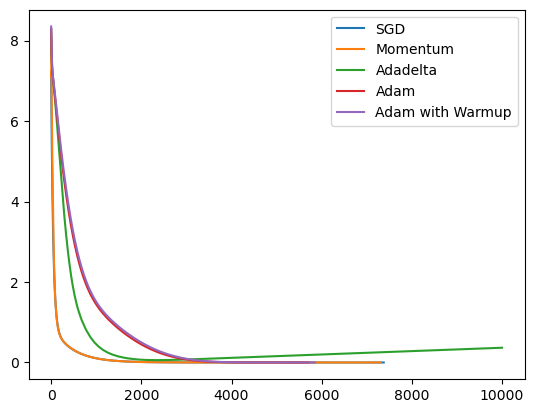

In [12]:
plt.plot(history_gd, label='SGD')
plt.plot(history_mo, label='Momentum')
plt.plot(history_add, label='Adadelta')
plt.plot(history_ada, label='Adam')
plt.plot(history_adawu, label='Adam with Warmup')
y_min = -5
y_max = 50
x_min = -5
x_max = 200
#plt.xlim([x_min,x_max])
#plt.ylim([y_min, y_max])
#plt.xscale('log')
plt.legend()
plt.show()

In [13]:
# For Ax = b, the solution is (A**-1 * b).T
print("Solution is: ", np.dot(np.linalg.inv(A),b).T)

Solution is:  [[0.30000007 0.39999992 0.        ]]


## 1.2. Function ${(1-x_0)}^2 + 100 {(x_1 - x_0^2)}^2$ 

### [ Rosenbrock function ]

In [14]:
def F(x):
  return np.power(1-x[0],2) + 100.0*np.power(x[1] - np.power(x[0],2),2)

# definition of loss function (F(x)) - let's see when this function is 0
def L(x):
  return F(x)

# definition of gradient
def g(x):
  return np.array([
    -(1-x[0]) - 100.0*4*x[0]*(x[1] - np.power(x[0],2)),
    100.0*2*(x[1] - np.power(x[0],2))
  ])

In [15]:
x1 = np.random.uniform(-1.0,1.0,size=(2,1))
x2 = np.copy(x1)
x3 = np.copy(x1)
x4 = np.copy(x1)
x5 = np.copy(x1)
alpha = 0.003
beta1 = 0.0
beta2 = 0.0

In [16]:
print(x1)

[[-0.14063802]
 [-0.86959616]]


In [17]:
x1, history_gd = GD(x1, alpha, verbose=True)

0 [12.27320934] [ 0.01287986 -0.33597103]
1 [2.78521699] [ 0.01064594 -0.13428888]
2 [1.26567414] [ 0.011897   -0.05364755]
3 [1.01855006] [ 0.01409339 -0.0213741 ]
4 [0.97449037] [ 0.01668627 -0.00843046]
5 [0.96273952] [ 0.01946183 -0.00320513]
6 [0.95609984] [ 0.02231975 -0.00105479]
7 [0.95027077] [ 0.02521119 -0.00012301]
8 [0.94458609] [0.02811261 0.00033216]
9 [0.93894875] [0.03101282 0.00060705]
10 [0.93334738] [0.03390658 0.0008199 ]
11 [0.92778201] [0.03679144 0.00101775]
12 [0.92225348] [0.03966624 0.00121927]
13 [0.91676229] [0.04253038 0.00143175]
14 [0.91130871] [0.04538355 0.001658  ]
15 [0.90589287] [0.04822552 0.001899  ]
16 [0.90051484] [0.05105615 0.00215502]
17 [0.89517464] [0.05387531 0.00242605]
18 [0.8898723] [0.05668287 0.00271195]
19 [0.88460781] [0.05947875 0.00301255]
20 [0.87938115] [0.06226283 0.00332765]
21 [0.87419229] [0.06503502 0.00365706]
22 [0.8690412] [0.06779524 0.00400055]
23 [0.86392783] [0.07054339 0.00435794]
24 [0.85885212] [0.07327941 0.00472

In [18]:
x2, history_mo = Momentum(x2, alpha, beta, verbose=True)

0 [70.47706971] [-0.12528623 -0.81623365]
1 [54.20804962] [-0.09862451 -0.71829157]
2 [36.03741492] [-0.06568331 -0.5864626 ]
3 [19.84097527] [-0.03106003 -0.43236991]
4 [8.16177438] [ 0.00202536 -0.26768641]
5 [2.02764462] [ 0.03203655 -0.10340983]
6 [1.10868727] [0.05893552 0.05070526]
7 [4.06363873] [0.08376095 0.18657493]
8 [8.99671128] [0.10818351 0.29808409]
9 [13.94573607] [0.13414915 0.38125951]
10 [17.30907448] [0.16362576 0.43432158]
11 [18.13659759] [0.19840788 0.45762455]
12 [16.25494965] [0.23991056 0.45350169]
13 [12.24157994] [0.28888995 0.42603444]
14 [7.27723367] [0.34506079 0.38075929]
15 [2.8785253] [0.40664699 0.32431012]
16 [0.46631217] [0.47000889 0.26396896]
17 [0.76032613] [0.52962225 0.20707828]
18 [3.22836373] [0.57874912 0.16028196]
19 [6.13551489] [0.61095896 0.12864538]
20 [7.55182429] [0.6221298  0.11484999]
21 [6.69130486] [0.611976   0.11876587]
22 [4.31912317] [0.58417253 0.13763509]
23 [1.90197806] [0.54500009 0.16683473]
24 [0.5030843] [0.50136694 0.2

In [19]:
x3, history_add = Adadelta(x3, alpha, verbose=True)

0 [80.32701539] [-0.14032132 -0.86927946]
1 [80.22423755] [-0.1398741  -0.86883224]
2 [80.09861092] [-0.13932666 -0.8682848 ]
3 [79.95384162] [-0.1386947  -0.86765282]
4 [79.79233257] [-0.13798825 -0.86694635]
5 [79.61581738] [-0.13721447 -0.86617253]
6 [79.42563161] [-0.13637876 -0.86533678]
7 [79.22285127] [-0.1354854  -0.86444337]
8 [79.00837181] [-0.13453791 -0.8634958 ]
9 [78.78295712] [-0.13353922 -0.86249702]
10 [78.5472716] [-0.13249182 -0.86144952]
11 [78.30190224] [-0.1313979  -0.86035547]
12 [78.04737431] [-0.13025936 -0.85921677]
13 [77.78416298] [-0.12907787 -0.85803511]
14 [77.512702] [-0.12785496 -0.856812  ]
15 [77.23339038] [-0.12659199 -0.8555488 ]
16 [76.94659767] [-0.12529019 -0.85424673]
17 [76.65266813] [-0.12395069 -0.85290694]
18 [76.35192411] [-0.12257454 -0.85153045]
19 [76.0446688] [-0.12116267 -0.85011821]
20 [75.73118853] [-0.11971599 -0.84867112]
21 [75.41175465] [-0.11823532 -0.84718999]
22 [75.08662514] [-0.11672141 -0.84567558]
23 [74.75604597] [-0.1151

In [20]:
x4, history_ada = Adam(x4, alpha, beta1, beta2, verbose=True)

1 [79.7123979] [-0.13763802 -0.86659616]
2 [79.0310468] [-0.13463802 -0.86359616]
3 [78.35578783] [-0.13163802 -0.86059616]
4 [77.68657997] [-0.12863802 -0.85759616]
5 [77.02338238] [-0.12563802 -0.85459616]
6 [76.36615442] [-0.12263802 -0.85159616]
7 [75.71485565] [-0.11963802 -0.84859616]
8 [75.06944582] [-0.11663802 -0.84559616]
9 [74.42988488] [-0.11363802 -0.84259616]
10 [73.79613295] [-0.11063802 -0.83959616]
11 [73.16815039] [-0.10763802 -0.83659616]
12 [72.54589771] [-0.10463802 -0.83359616]
13 [71.92933563] [-0.10163802 -0.83059616]
14 [71.31842508] [-0.09863802 -0.82759616]
15 [70.71312716] [-0.09563802 -0.82459616]
16 [70.11340318] [-0.09263802 -0.82159616]
17 [69.51921464] [-0.08963802 -0.81859616]
18 [68.93052324] [-0.08663802 -0.81559616]
19 [68.34729086] [-0.08363802 -0.81259616]
20 [67.76947958] [-0.08063802 -0.80959616]
21 [67.19705169] [-0.07763802 -0.80659616]
22 [66.62996965] [-0.07463802 -0.80359616]
23 [66.06819613] [-0.07163802 -0.80059616]
24 [65.51169399] [-0.0

In [21]:
x5, history_adawu = AdamWithWarmup(x5, ramp_n, alpha, beta1, beta2, verbose=True)

1 [80.33085673] [-0.14033802 -0.86929616]
2 [80.19299056] [-0.13973802 -0.86869616]
3 [79.98665336] [-0.13883802 -0.86779616]
4 [79.7123979] [-0.13763802 -0.86659616]
5 [79.37095826] [-0.13613802 -0.86509616]
6 [78.96324744] [-0.13433802 -0.86329616]
7 [78.49035423] [-0.13223802 -0.86119616]
8 [77.9535396] [-0.12983802 -0.85879616]
9 [77.35423244] [-0.12713802 -0.85609616]
10 [76.69402473] [-0.12413802 -0.85309616]
11 [76.03976641] [-0.12113802 -0.85009616]
12 [75.39141713] [-0.11813802 -0.84709616]
13 [74.74893674] [-0.11513802 -0.84409616]
14 [74.11228527] [-0.11213802 -0.84109616]
15 [73.48142297] [-0.10913802 -0.83809616]
16 [72.85631027] [-0.10613802 -0.83509616]
17 [72.23690779] [-0.10313802 -0.83209616]
18 [71.62317635] [-0.10013802 -0.82909616]
19 [71.01507696] [-0.09713802 -0.82609616]
20 [70.41257084] [-0.09413802 -0.82309616]
21 [69.81561938] [-0.09113802 -0.82009616]
22 [69.22418419] [-0.08813802 -0.81709616]
23 [68.63822704] [-0.08513802 -0.81409616]
24 [68.05770994] [-0.0

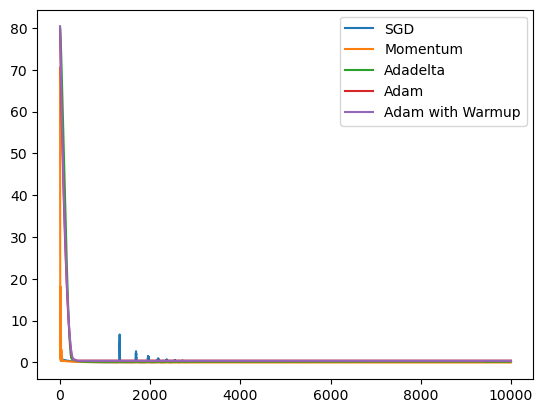

In [22]:
plt.plot(history_gd, label='SGD')
plt.plot(history_mo, label='Momentum')
plt.plot(history_add, label='Adadelta')
plt.plot(history_ada, label='Adam')
plt.plot(history_adawu, label='Adam with Warmup')
plt.legend()
plt.show()

## 1.3. Deep Learning Package From Lab2

Using the package you created in lab2, define a network and train the loss functions specified before. Plot accuracy of models.

In [23]:
import numpy as np

from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 784).astype(np.float32)
x_test = x_test.reshape(x_test.shape[0], 784).astype(np.float32)

y_train = to_categorical(y_train, 10).astype(np.float32)
y_test = to_categorical(y_test, 10).astype(np.float32)

print(x_train.shape, y_train.shape)

(60000, 784) (60000, 10)


In [24]:
x_train.shape, y_train.shape
# B = 120 (train set), B = 30 (test set)

((60000, 784), (60000, 10))

In [25]:
np.min(x_train, axis=0), np.max(x_train, axis=0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [26]:
np.min(x_test, axis=0), np.max(x_test, axis=0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

(784, 10) (10,) (10, 10) (10,)
0 1.156967979795164 1.1191827388431888 0.075 0.1179


C:\Users\Owner\AppData\Local\Temp\ipykernel_11592\2024862181.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


100 0.32947778624882373 0.3435771590090031 0.25 0.1648
200 0.3379741716407851 0.32447790373121044 0.15 0.2236
300 0.3189115846774422 0.314864220345398 0.225 0.2421
400 0.31321812869690857 0.2980802118105364 0.225 0.2959
500 0.27804220150243314 0.29125756793664603 0.45 0.3257
600 0.2694450328203332 0.2878601710352765 0.375 0.309
700 0.2726557693987081 0.2793598965655542 0.4 0.3657
800 0.28099214398965944 0.28658652555959585 0.25 0.2776
900 0.2514784590356221 0.27404266376601316 0.525 0.3731
1000 0.24680690056601967 0.26074170921788253 0.425 0.4322
1100 0.26349470078060183 0.25485557401842235 0.35 0.4319
1200 0.2563555018789831 0.2446548962687076 0.475 0.4672
1300 0.2223431044881633 0.24124402788658025 0.625 0.4764
1400 0.23662584861857694 0.25443397689723124 0.4 0.3939
1500 0.2439756033749581 0.2490007715614263 0.425 0.4217
1600 0.22799637832997582 0.24227835789605512 0.5 0.4461
1700 0.24061856396070014 0.2336596348508166 0.475 0.4888
1800 0.2578080594406303 0.230173436663384 0.4 0.5023

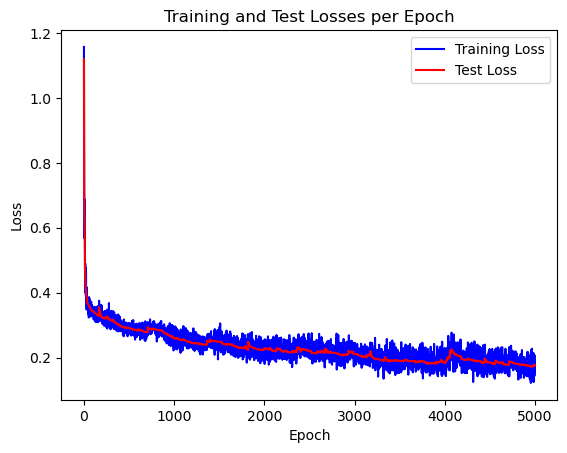

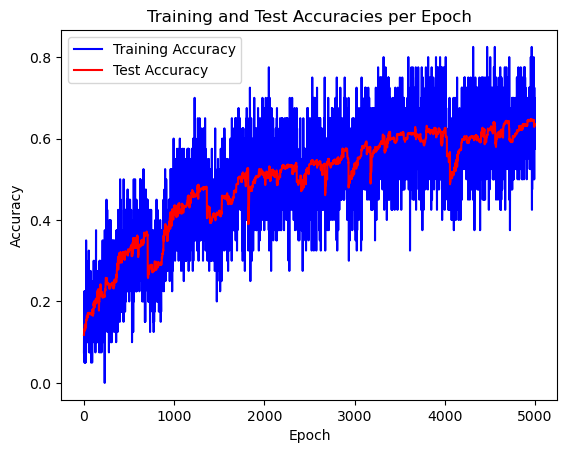

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(y,p):
    lossValue = - np.mean(y * np.log(p) + (1-y) * np.log(1-p))
    return - np.mean(y * np.log(p) + (1-y) * np.log(1-p))

# N0 inputs -> N1 nodes -> N2 outputs
# N0 = 4, N1 = 10, N2 = 3

def init(N0, N1, N2, seed=None):
    if seed is not None:
        np.random.seed(seed)
    w1 = np.random.randn(N0,N1)
    b1 = np.zeros(N1)
    w2 = np.random.randn(N1,N2)
    b2 = np.zeros(N2)
    
    # [ [w1, b1, 'sigmoid'], [w2, b2, 'sigmoid'] ]
    
    print(w1.shape, b1.shape, w2.shape, b2.shape)
    
    return w1, b1, w2, b2

def forward(x, w1, b1, w2, b2):
    z1 = np.dot(x,w1) + b1
    y1 = sigmoid(z1)
    z2 = np.dot(y1,w2) + b2
    y2 = sigmoid(z2)
    
    # [{'y': y1, 'z': z1}, {'y': y2, 'z': z2}]
    
    return z1, y1, z2, y2

def backward(x, y, w1, b1, w2, b2):
    B = x.shape[0]
    
    z1, y1, z2, p = forward(x, w1, b1, w2, b2)
    y0 = x
    
    # import pdb; pdb.set_trace()
    # for BCE (y * log(p) + (1-y) * log(1-p))
    dy2 = - (y / p - (1-y)/(1-p))
    
    # dy2 = - (y - y2) for MSE (y - y2)**2 / 2
    
    
    dz2 = dy2 * sigmoid(z2) * (1-sigmoid(z2)) # (B, N2)
    # remember I said in class dw2 is transposed from the notes
    dw2 = np.dot(y1.T, dz2) / B   # (N1, N2)
    db2 = np.mean(dz2, axis=0)    # (N2)
    dy1 = np.dot(dz2, w2.T)       # (B, N1)
    
    dz1 = dy1 * sigmoid(z1) * (1-sigmoid(z1)) # (B, N1)
    dw1 = np.dot(y0.T, dz1) / B   # (N0, N1)
    db1 = np.mean(dz1, axis=0)    # (N1)
    
    # [{'dw': dw1, 'db': db1}, {'dw': dw2, 'db': db2}]
    
    return dw1, db1, dw2, db2, p

def sgd(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    
    return w1, b1, w2, b2

def accuracy(y, p):
    return np.mean(np.argmax(y, axis=-1) == np.argmax(p, axis=-1))

def train(x, y, x_test, y_test, alpha, epochs, batch_size=-1):
    if batch_size == -1:
        batch_size = x.shape[0]
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    w1, b1, w2, b2 = init(x.shape[1], 10, y.shape[1], seed=42)
    for e in range(epochs):
        idx = np.arange(x.shape[0]) # [0, 1, ..., x.shape[0]-1]
        np.random.shuffle(idx)
        idx = idx[:batch_size]
        dw1, db1, dw2, db2, p = backward(
            x[idx], y[idx], w1, b1, w2, b2)
        w1, b1, w2, b2 = sgd(
            w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        train_loss = loss(y[idx], p)
        _, _, _, p_test = forward(x_test, w1, b1, w2, b2)
        test_loss = loss(y_test, p_test)

        train_acc = accuracy(y[idx], p)
        _, _, _, p_test = forward(x_test, w1, b1, w2, b2)
        test_acc = accuracy(y_test, p_test)
        if e % 100 == 0:
            print(e, train_loss, test_loss, train_acc, test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
    return w1, b1, w2, b2, train_losses, test_losses, train_accuracy, test_accuracy

w1, b1, w2, b2, train_losses, test_losses, train_accuracy, test_accuracy = train(
    x_train, y_train, x_test, y_test, 0.1, 5000, 40)

# Plot training and test losses
plt.figure()
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Training and Test Losses per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
# Plot training and test accuracies
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(test_accuracy, label='Test Accuracy', color='red')
plt.title('Training and Test Accuracies per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
_, _, _, p_test = forward(x_test, w1, b1, w2, b2)
print('accuracy:', 
      np.mean(np.argmax(p_test, axis=-1) == np.argmax(y_test, axis=-1)))

accuracy: 0.6359


C:\Users\Owner\AppData\Local\Temp\ipykernel_11592\2024862181.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [29]:
np.argmax(y_test, axis=-1)

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

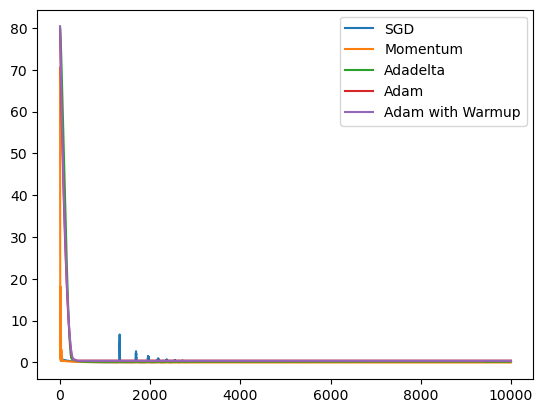

In [30]:
plt.plot(history_gd, label='SGD')
plt.plot(history_mo, label='Momentum')
plt.plot(history_add, label='Adadelta')
plt.plot(history_ada, label='Adam')
plt.plot(history_adawu, label='Adam with Warmup')
plt.legend()
plt.show()

# 2. Data Visualization

You should look at https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b, which contains a very nice introduction into visualizing datasets using PCA
and tSNE.

In [31]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [32]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [33]:
x_train = x_train / 255.0

To create a permutation of the inputs, we can just permute the indexes.

In [34]:
indexes = x_train.shape[0]
indexes = np.random.permutation(indexes)
indexes

array([12534, 10643, 15758, ...,  6044, 24695, 41017])

In [35]:
x_train = x_train[indexes]
y_train = y_train[indexes]

<Figure size 640x480 with 0 Axes>

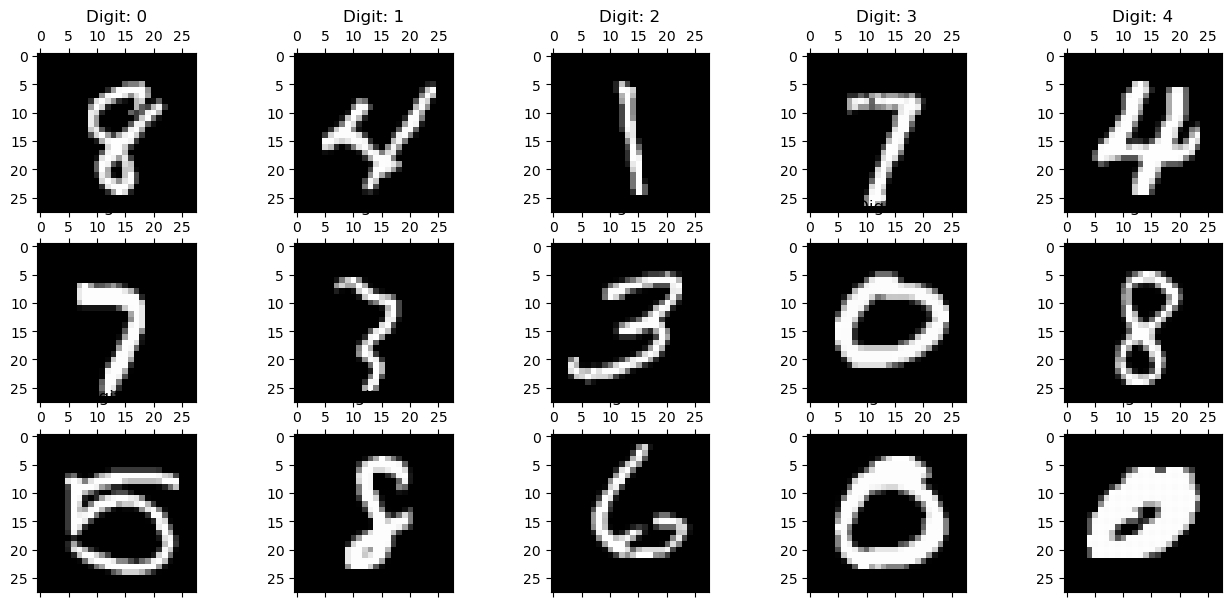

In [36]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    x = x_train[i]
    y = y_train[i]
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(i)))
    ax.matshow(x)
plt.show()


In [37]:
# we will just use the first 10000 samples
x_train_flatten = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
y_train_flatten = y_train.reshape(y_train.shape[0])
#x_train_flatten = x_train_flatten[0:1000]
#y_train_flatten = y_train_flatten[0:1000]
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train_flatten)

C:\Users\Owner\AppData\Local\Temp\ipykernel_11592\4122248994.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


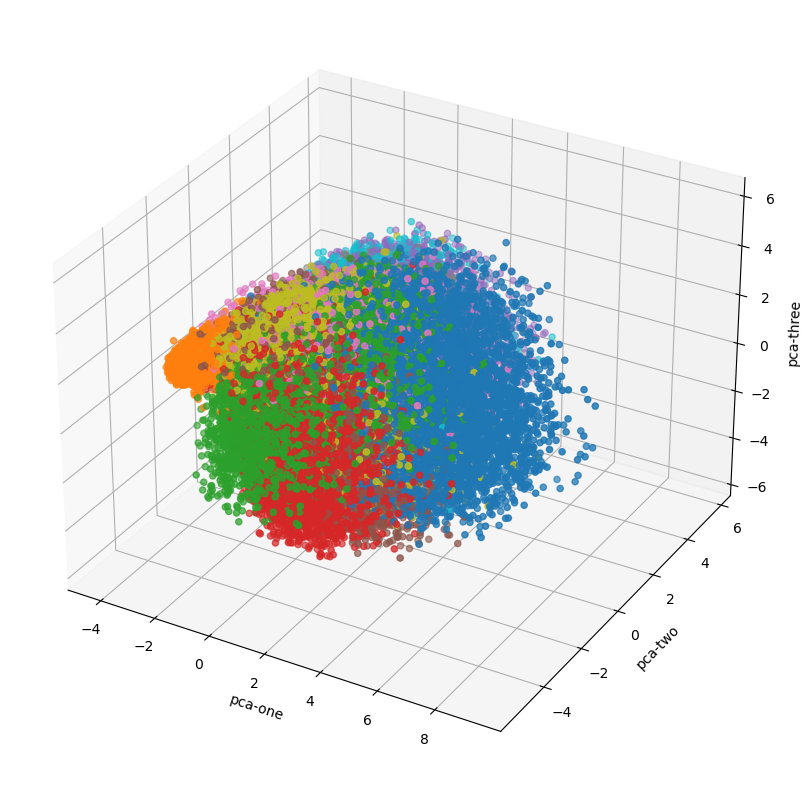

In [38]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y_train_flatten, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()



In [39]:
# tSNE is very expensive to compute. Let's use only 3000 samples
x_train_flatten = x_train_flatten[0:3000]
y_train_flatten = y_train_flatten[0:3000]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train_flatten)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.003s...
[t-SNE] Computed neighbors for 3000 samples in 0.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.486242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.509720
[t-SNE] KL divergence after 300 iterations: 1.950051
t-SNE done! Time elapsed: 2.1496665477752686 seconds


In [40]:
data = {"x{}".format(i): x_train_flatten[:, i] for i in range(x_train_flatten.shape[1])}
data["y"] = y_train_flatten
df = pd.DataFrame(data)

In [41]:
df

x0   x1   x2   x3   x4   x5   x6   x7   x8   x9  ...  x775  x776  x777  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
2995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

      x778  x779  x780  x781  x782  x783  y  
0      0.0   0.0   0.0   0.0   0.0   0.0  8  
1      0.0   0.0   0.0   0.0   0.0   0.0  4  
2      0.0   0.0   0.0   0.0   0.0   0.0  1  
3      0.0   0.0   0.0   0.0   0.0   0.0  7  
4      0.0   0.0   0.0   0.0   0.0   0.0  4  
...    ...   ...   ...   ...   ...   ... ..  
2995   0.0   0.0   0.0   0.0   0.0   0.0  7  
2996   0.0   0.0   0.0   0.0   0.0   0.0  7  
2997   0.0   0.0   0.0   0.0   0.0   0.0  8  
2998   0.0   0.0   0.0   0.0   0.0   0.0  6  
2999   0.0   0.0   0.0   0.0   0.0   0.0  5  

[3000 rows x 785 columns]

<AxesSubplot:>

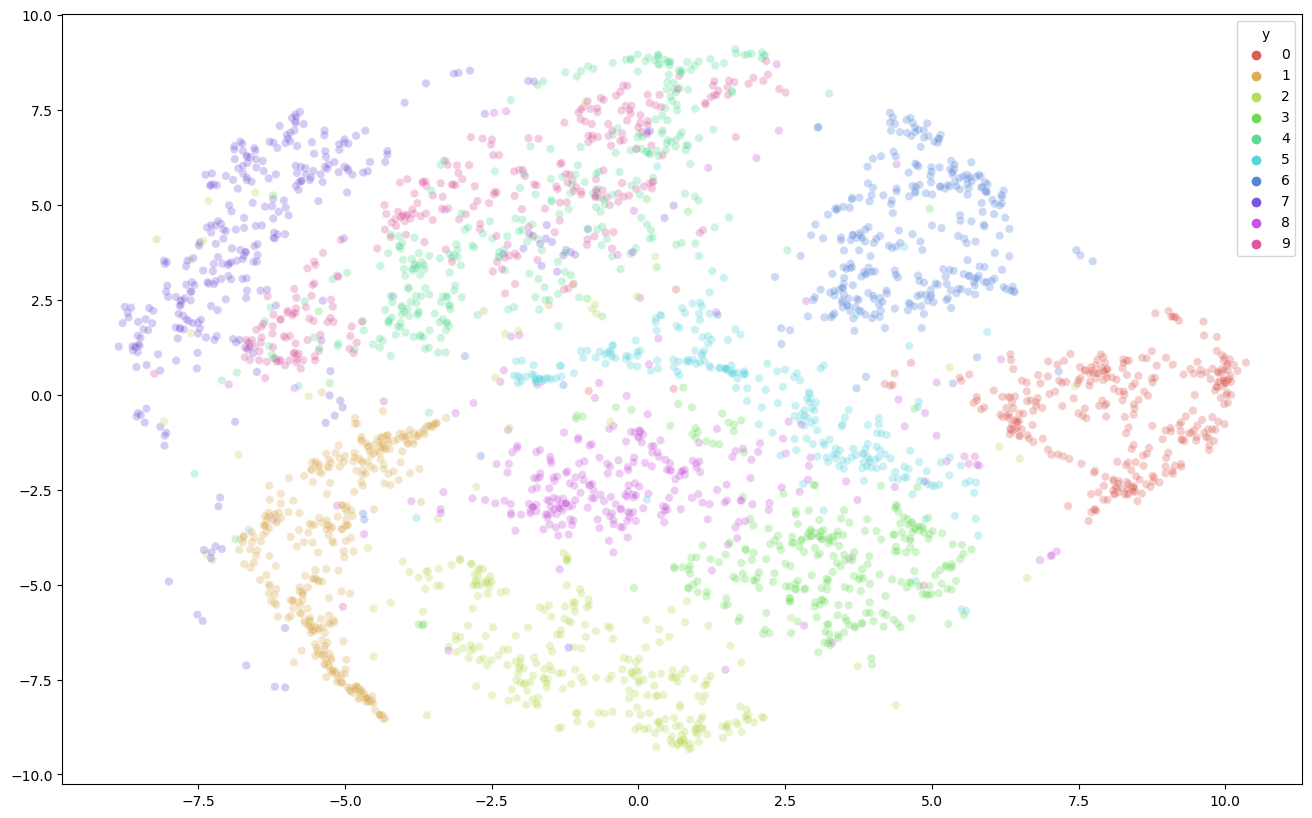

In [42]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)


In [43]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_train_flatten)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8297451664605137


In [44]:
x_train_flatten.shape, y_train_flatten.shape, pca_result_50.shape

((3000, 784), (3000,), (3000, 50))

In [45]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_50)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.274505
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.088715
[t-SNE] KL divergence after 300 iterations: 1.910780


<AxesSubplot:>

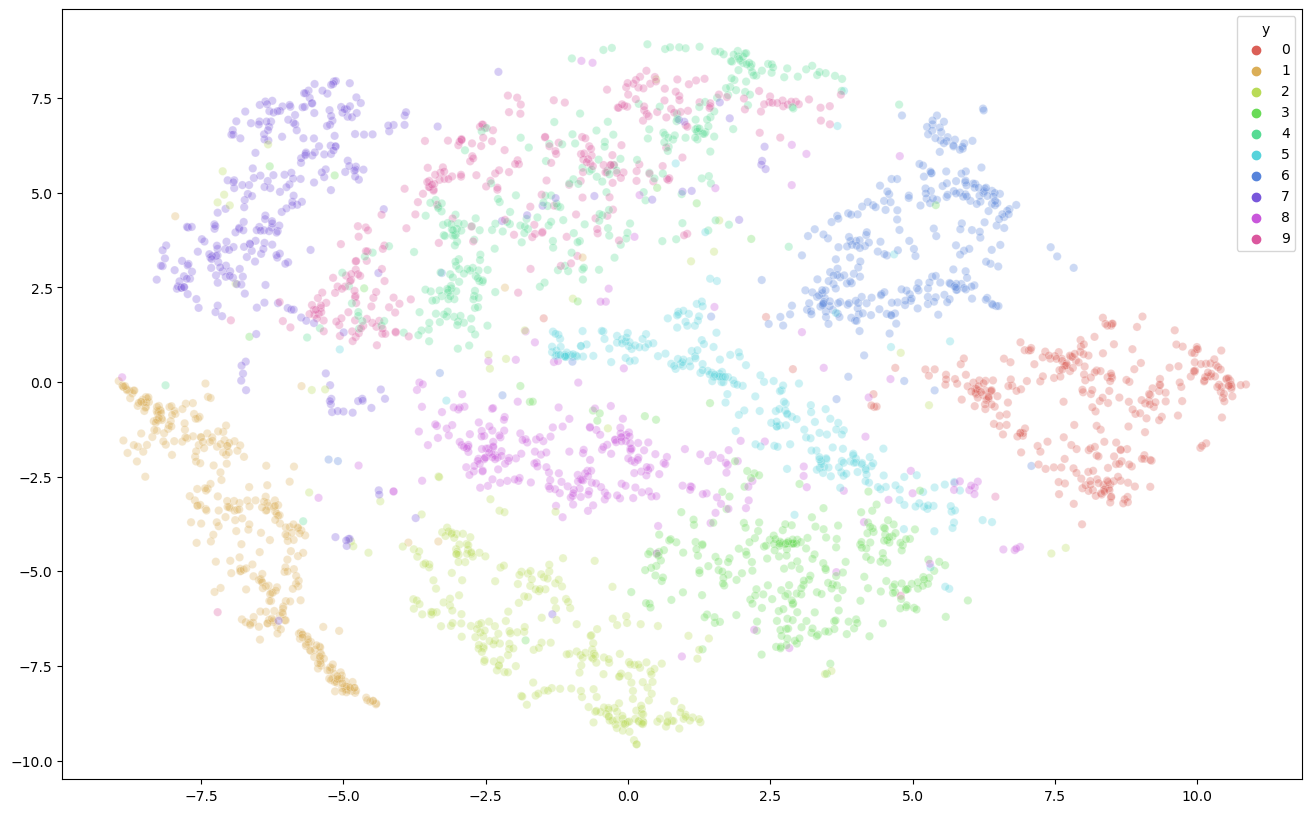

In [46]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

Now, you will perform the same exercise on cifar10 or cifar100.

In [47]:
from keras.datasets import cifar10

In [48]:
# your code goes here

(x_train, y_train), (x_test, y_test)= cifar10.load_data()

In [49]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [50]:
x_train = x_train / 255.0

In [51]:
indexes = x_train.shape[0]
indexes = np.random.permutation(indexes)
indexes

array([40244, 41561,  4438, ...,  9803, 45325,  6942])

In [52]:
x_train = x_train[indexes]
y_train = y_train[indexes]

<Figure size 640x480 with 0 Axes>

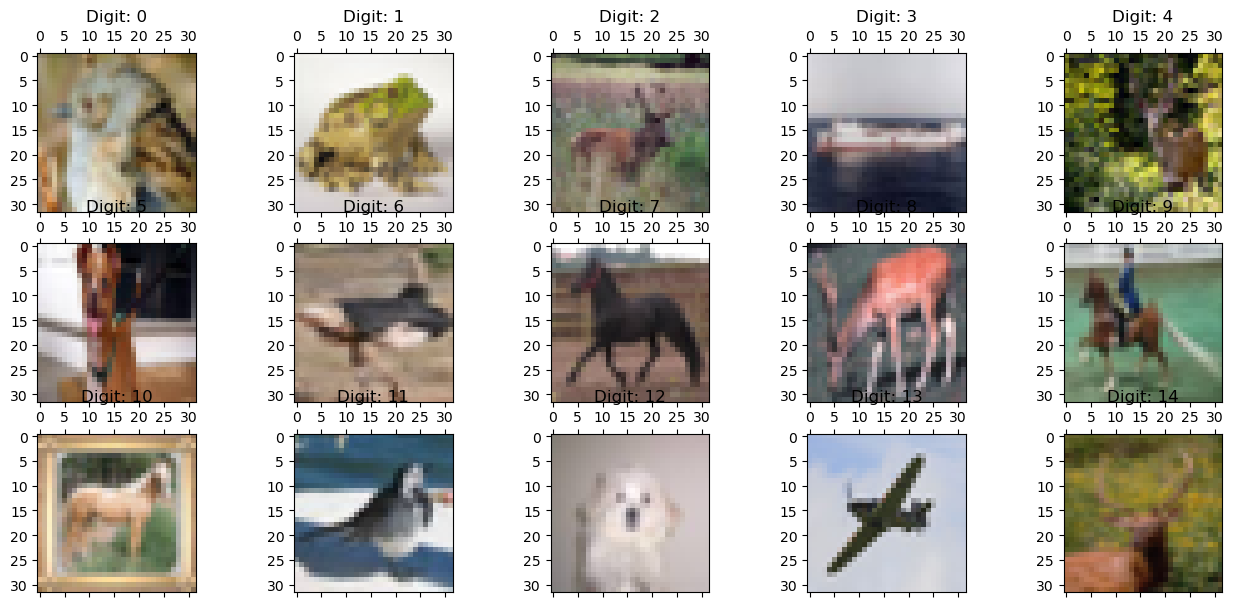

In [53]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    x = x_train[i]
    y = y_train[i]
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(i)))
    ax.matshow(x)
plt.show()


In [54]:
# we will just use the first 10000 samples
x_train_flatten = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
y_train_flatten = y_train.reshape(y_train.shape[0])
#x_train_flatten = x_train_flatten[0:1000]
#y_train_flatten = y_train_flatten[0:1000]
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train_flatten)

C:\Users\Owner\AppData\Local\Temp\ipykernel_11592\4122248994.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


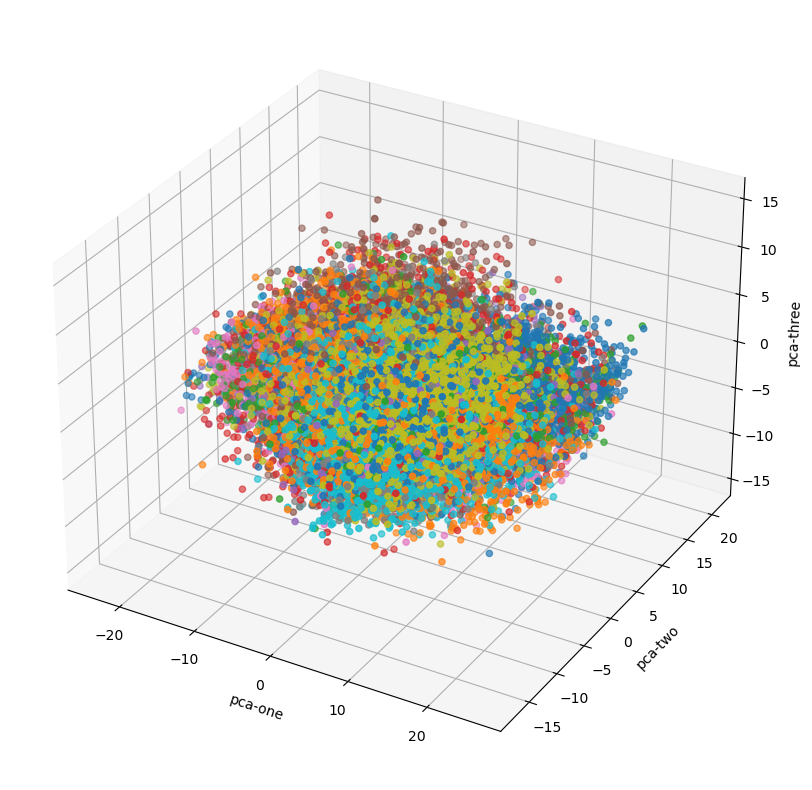

In [55]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y_train_flatten, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()



In [56]:
# tSNE is very expensive to compute. Let's use only 3000 samples
x_train_flatten = x_train_flatten[0:3000]
y_train_flatten = y_train_flatten[0:3000]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train_flatten)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.010s...
[t-SNE] Computed neighbors for 3000 samples in 0.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.469432
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.754654
[t-SNE] KL divergence after 300 iterations: 2.348334
t-SNE done! Time elapsed: 2.608765125274658 seconds


In [57]:
data = {"x{}".format(i): x_train_flatten[:, i] for i in range(x_train_flatten.shape[1])}
data["y"] = y_train_flatten
df = pd.DataFrame(data)

In [58]:
df

x0        x1        x2        x3        x4        x5        x6  \
0     0.576471  0.533333  0.439216  0.556863  0.505882  0.384314  0.501961   
1     0.956863  0.952941  0.937255  0.945098  0.941176  0.925490  0.949020   
2     0.215686  0.200000  0.203922  0.313725  0.329412  0.274510  0.364706   
3     0.850980  0.843137  0.870588  0.835294  0.831373  0.854902  0.827451   
4     0.486275  0.509804  0.172549  0.286275  0.282353  0.176471  0.298039   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.729412  0.749020  0.725490  0.627451  0.650980  0.611765  0.776471   
2996  0.145098  0.066667  0.000000  0.113725  0.043137  0.011765  0.105882   
2997  0.509804  0.486275  0.396078  0.564706  0.541176  0.450980  0.603922   
2998  0.141176  0.329412  0.650980  0.145098  0.333333  0.639216  0.145098   
2999  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

            x7        x8        x9  ...     x3063     x3064     x3065  \
0     0.458824  0.278431  0.470588  ...  0.443137  0.396078  0.250980   
1     0.945098  0.929412  0.952941  ...  0.768627  0.745098  0.752941   
2     0.380392  0.301961  0.313725  ...  0.368627  0.376471  0.301961   
3     0.823529  0.847059  0.819608  ...  0.090196  0.117647  0.200000   
4     0.309804  0.137255  0.266667  ...  0.858824  0.796078  0.552941   
...        ...       ...       ...  ...       ...       ...       ...   
2995  0.800000  0.749020  0.623529  ...  0.764706  0.423529  0.403922   
2996  0.039216  0.015686  0.094118  ...  0.329412  0.282353  0.145098   
2997  0.580392  0.490196  0.600000  ...  0.196078  0.098039  0.011765   
2998  0.337255  0.639216  0.145098  ...  0.047059  0.266667  0.584314   
2999  1.000000  1.000000  1.000000  ...  0.592157  0.615686  0.607843   

         x3066     x3067     x3068     x3069     x3070     x3071  y  
0     0.415686  0.368627  0.180392  0.396078  0.356863  0.188235  2  
1     0.764706  0.741176  0.749020  0.756863  0.733333  0.741176  6  
2     0.356863  0.376471  0.294118  0.352941  0.372549  0.329412  4  
3     0.133333  0.156863  0.235294  0.156863  0.172549  0.243137  8  
4     0.850980  0.811765  0.450980  0.768627  0.725490  0.376471  4  
...        ...       ...       ...       ...       ...       ... ..  
2995  0.776471  0.431373  0.415686  0.784314  0.435294  0.419608  1  
2996  0.309804  0.262745  0.113725  0.305882  0.254902  0.101961  6  
2997  0.243137  0.121569  0.031373  0.274510  0.152941  0.047059  5  
2998  0.047059  0.266667  0.588235  0.043137  0.274510  0.596078  0  
2999  0.615686  0.647059  0.635294  0.611765  0.658824  0.639216  5  

[3000 rows x 3073 columns]

<AxesSubplot:>

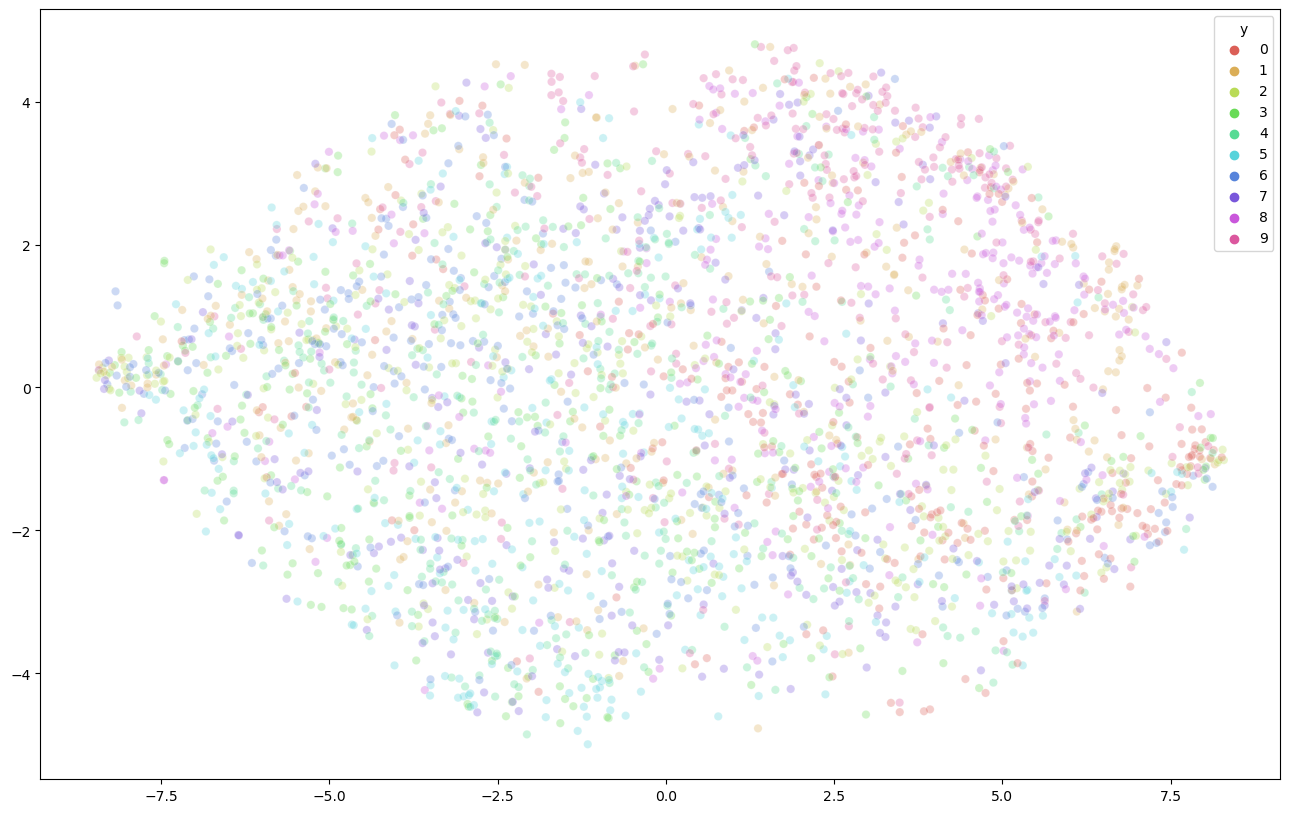

In [59]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)


In [60]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_train_flatten)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8493007753939865


In [61]:
x_train_flatten.shape, y_train_flatten.shape, pca_result_50.shape

((3000, 3072), (3000,), (3000, 50))

In [62]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_50)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.251345
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.388687
[t-SNE] KL divergence after 300 iterations: 2.580334


<AxesSubplot:>

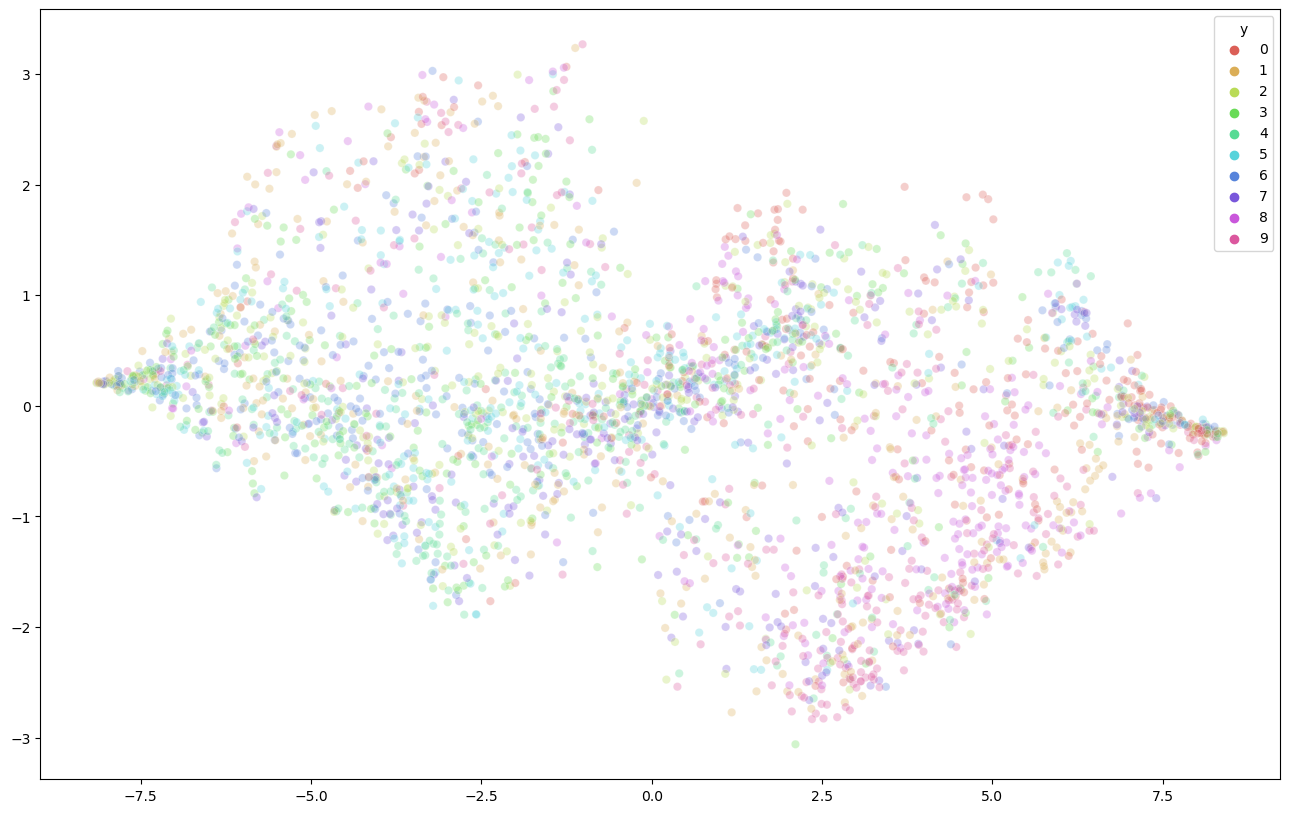

In [63]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

With the help of ChatGPT, explain the difference among PCA (SVD if you remove mean(x) and compute np.dot(X.T, X) to create a square matrix), tSNE and UMAP, explaining how it works.  I will be checking if you left ChatGPT generating the sentences and it ended up writing garbage.

PCA is great for cutting the number of dimensions down drastically while trying to retain the variation as much as possible. Uses an orthogonal transformation to project data onto the lower dimensional space i.e. data in a 3d space projected onto a 2d plane, or data from a 2d plane onto a 1d line. It is fast and computationally efficient, especially for linear data. Visually, PCA makes it harder to see differences in clusters of data points.

For t-SNE (T-distributed stochastic neighbour embedding) is great for VISUALIZATION of high-dimensional datasets, giving a visual format on a lower dimensional graph (2D or 3D) and gives data points a location in a map. It sections clusters in the data and creates these hotspots, where these clusters of data will cluster around a specific spot while keeping similar clusters close and others apart. 

UMAP implements different hyper parameters:
* n-neighbors - controls how UMAP balances local versus global structure in the data
* min-dist - controls how tightly UMAP can pack points together
* n_components - dimensionality of reduced dimension space
* metric - how distance is computed

UMAP does a great job in seperating data points compared to t-SNE and PCA.

In terms of computational times, PCA is the fastest, while t-SNE is the slowest by nearly a margin of 300x. t-SNE typically requires another dimensionality reduction method(PCA, etc.) before being used. PCA is not great at differentiating the different data clusters.

According to the article, even though it was not mentioned in this question, LDA performed the best.